# 

# Prueba Ingeniero de Datos – Comercial Nutresa 2021.
## Contexto.
La compañía para la cual trabaja desea contar con una herramienta que le permita identificar anticipadamente los clientes que se van a retirar en el siguiente periodo, con el objetivo de implementar planes de acción que logren reducir este comportamiento tanto como sea posible. Por este motivo, se le ha encargado construir un modelo que a partir de la base de datos suministrada permita predecir, con la mayor precisión posible, la variable “Retiro”.
## Definicion del objetivo.
Identificar de forma anticipada el retiro de clientes para el siguiente periodo.
## Pasos a seguir.
- ### 1) [Conocer la información.](#cell2)
  * Análisis preliminar.
  * Análisis de las variables independientes.
  * Análisis de la variable dependiente ('Retiro').
  * Relaciones entre la variable dependiente y las variables independientes.
- ### 2) [Preprocesamiento de la información.](#cell3)
  * Manejo de datos faltantes y errados.
  * Manejo Variables categóricas.
  * Partición de los datos entre variables dependientes y variables independientes.
  * Manejo de datos atípicos y skewness.
  * División de los datos (entrenamiento y test)
- ### 3) [Creación y evaluación de los modelos.](#cell4)
  * Identificar patrones por medio de clustering.
  * Reducción de dimensiones.
  * Identificar el modelo que presente el mejor rendimiento.
  * Notas finales respecto a los modelos.
- ### 4) [Solución final y propuesta](#cell5)
  * Notas generales.
  * Solución.

In [1]:
# Importar dependencias necesarias.
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
import numpy as np
from sklearn.cluster import KMeans
from xgboost import XGBRegressor
from scipy.stats import norm, kurtosis, skew
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import ElasticNet
from sklearn.metrics import r2_score
from scipy import stats
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline


## 1) Conocer la información.<a id="cell2"></a>
**Análisis preliminar.** - Crearemos un archivo de Excel donde evaluaremos cada variable o columna teniendo en cuenta los siguientes aspectos.
* **Variable**: Nombre de la variable.
* **Tipo**: Identificación del tipo de las variables ('Discreta') o ('Continua').
* **Impacto**: Nuestra expectativa sobre el impacto de la variable respecto a ('Retiro'). Se utilizaran las variables ('Alto')('Medio') y ('Bajo')
* **Comentarios**: Comentarios adicionales sobre la variable.

In [2]:
#Cargar los datos.
dt_file = pd.read_csv('Data.csv', delimiter=',')

In [3]:
#Columnas que componen nuestros datos.
dt_file.columns

Index(['Id', 'Lifetime', 'user_intake', 'user_no_outgoing_activity_in_days',
       'user_account_balance_last', 'user_spendings',
       'user_has_outgoing_calls', 'user_has_outgoing_sms', 'user_use_gprs',
       'user_does_reload', 'reloads_inactive_days', 'reloads_count',
       'reloads_sum', 'calls_outgoing_count', 'calls_outgoing_spendings',
       'calls_outgoing_duration', 'calls_outgoing_spendings_max',
       'calls_outgoing_duration_max', 'calls_outgoing_inactive_days',
       'calls_outgoing_to_onnet_count', 'calls_outgoing_to_onnet_spendings',
       'calls_outgoing_to_onnet_duration',
       'calls_outgoing_to_onnet_inactive_days',
       'calls_outgoing_to_offnet_count', 'calls_outgoing_to_offnet_spendings',
       'calls_outgoing_to_offnet_duration',
       'calls_outgoing_to_offnet_inactive_days',
       'calls_outgoing_to_abroad_count', 'calls_outgoing_to_abroad_spendings',
       'calls_outgoing_to_abroad_duration',
       'calls_outgoing_to_abroad_inactive_days', 's

In [4]:
# Vista previa del archivo
dt_values_description = pd.read_csv('variables_data.csv', delimiter=',')
dt_values_description.tail(n=-2)

,Variable,Tipo,Impacto,Comentarios
2,user_intake,Discreta,Medio,Puede hacer referencia a si el cliente fue o ...
3,user_no_outgoing_activity_in_days,Continua,Medio,NaN
4,user_account_balance_last,Continua,Medio,NaN
5,user_spendings,Continua,Alto,NaN
6,user_has_outgoing_calls,Continua,Baja,Tiene valores negativos.
...,...,...,...,...
59,last_100_sms_outgoing_to_onnet_count,Continua,Baja,NaN
60,last_100_sms_outgoing_to_offnet_count,Continua,Baja,Tiene valores negativos y outliers.
61,last_100_sms_outgoing_to_abroad_count,Continua,Baja,Tiene valores negativos y outliers.
62,last_100_gprs_usage,Continua,Baja,Tiene valores negativos y outliers.


Del análisis anterior se logró obtener los siguientes insights.
* Existen 63 variables independientes.
* Las siguientes variables independientes son discretas ```Id,user_intake,user_use_gprs,user_does_reload```, las variables restantes son continuas.<br>
* Cada observación hace referencia a un cliente y sus respectivas características-variables.<br>
* Los servicios prestados por la empresa se pueden clasificar en 3 segmentos ```llamadas, sms y gprs```.<br>
* No existe una variable que indique periodos o tiempos de inicio o finalización.<br>

* La variable dependiente ('Retiro') es continua y hace referencia al número de retiros totales de la empresa. Aunque se expresa por usuario este no podría tener 4000 retiros, a lo mucho tendría 1.
* Un incremento en la variable dependiente ('Retiro') implica algo negativo.

Existen algunos interrogantes:

* No existe una variable que indique si el usuario se retira o no del servicio. 
* No se identifica noción de tiempo en los datos.

**Análisis de las variables independientes.<br>Skewness y Kurtosis en las variables independientes.**<br>
Identificar cuáles variables presentan un sesgo moderado aceptable y valores atípicos aceptables

In [5]:
# Resumen descriptivo estadístico
dt_file.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Id,66469.0,594857.224390,429242.305254,13.0,250107.0,413512.0,1041120.0,1196944.0
Lifetime,66469.0,4006.037867,6058.350935,0.0,457.0,1216.0,1985.0,15947.0
user_intake,66469.0,0.040365,0.196815,0.0,0.0,0.0,0.0,1.0
user_no_outgoing_activity_in_days,66469.0,63.975718,264.006882,0.0,1.0,2.0,8.0,1307.0
user_account_balance_last,66469.0,9.286705,18.406509,0.0,0.0,5.0,12.0,1775.0
...,...,...,...,...,...,...,...,...
last_100_sms_outgoing_to_onnet_count,66469.0,116.180716,361.383684,0.0,0.0,0.0,1.0,4339.0
last_100_sms_outgoing_to_offnet_count,66469.0,69.760385,282.986930,-5.0,0.0,0.0,1.0,9024.0
last_100_sms_outgoing_to_abroad_count,66469.0,69.544389,276.622716,-5.0,0.0,0.0,3.0,4730.0
last_100_gprs_usage,66469.0,186.652048,437.028626,-3.0,0.0,0.0,27.0,5892.0


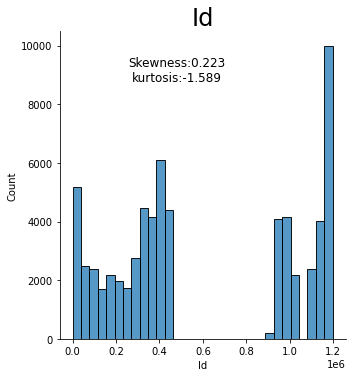

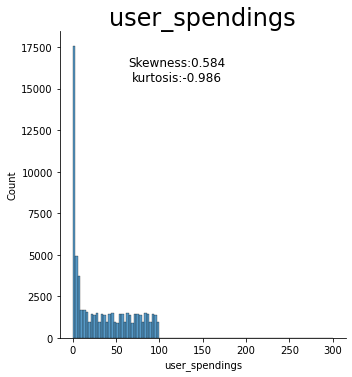

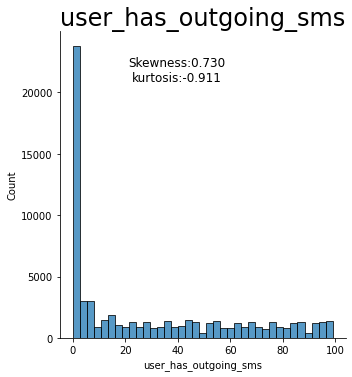

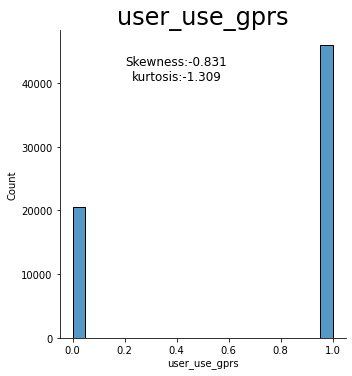

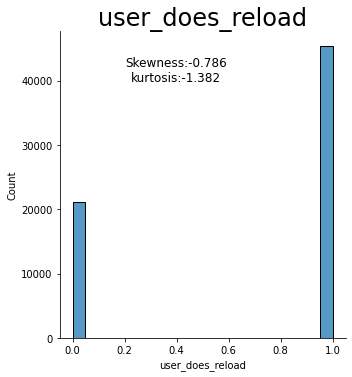

In [6]:
for col in dt_file:
    skew_value = dt_file[col].skew()
    kurt_value = dt_file[col].kurt()
    # Se filtran las variables según el valor de su kurt y skew 
    if kurt_value > -2 and kurt_value < 2:
        if skew_value > -1 and skew_value < 1:
            skew_value = "{:.3f}".format(skew_value)
            kurt_value = "{:.3f}".format(kurt_value)
            sns.displot(dt_file[col]) 
            plt.title(f"{col}", size=24)
            plt.suptitle(f"Skewness:{skew_value}\nkurtosis:{kurt_value}", y=0.9, fontsize=12)

**Las siguientes variables independientes tienen un sesgo moderado aceptable y valores atípicos aceptables**
<br>
```* Variable= user_spendings kurt_value=-0.9856274944152101 skew_value=0.5836142584469972```<br>
```* Variable= user_has_outgoing_sms kurt_value=-0.9113218938880436 skew_value=0.7300935810171704```<br>
```* Variable= user_use_gprs kurt_value=-1.3087464407599068 skew_value=-0.8314402800549751```<br>
```* Variable= user_does_reload kurt_value=-1.382170960555013 skew_value=-0.7860474723506953```<br>
Nota: Las variables restantes tienen sesgos considerables y/o valores atípicos no aceptables.

**Análisis de la variable dependiente ('Retiro')**

In [7]:
# Resumen descriptivo estadístico
dt_file['Retiro'].describe()

count    66469.000000
mean       159.498398
std        404.775799
min        -38.000000
25%          0.000000
50%          1.000000
75%         24.000000
max       4859.000000
Name: Retiro, dtype: float64

Skewness: 2.395131
Kurtosis: 3.983621


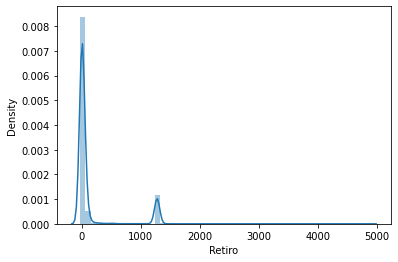

In [8]:
sns.distplot(dt_file['Retiro']);
print("Skewness: %f" % dt_file['Retiro'].skew())
print("Kurtosis: %f" % dt_file['Retiro'].kurt())

* Se desvía de la distribución normal.
* Tiene una asimetría positiva apreciable.
* Muestra picos.
* Presenta valores atípicos.

**Relaciones entre la variable dependiente y las variables independientes.**<br>
    Correlaciones.

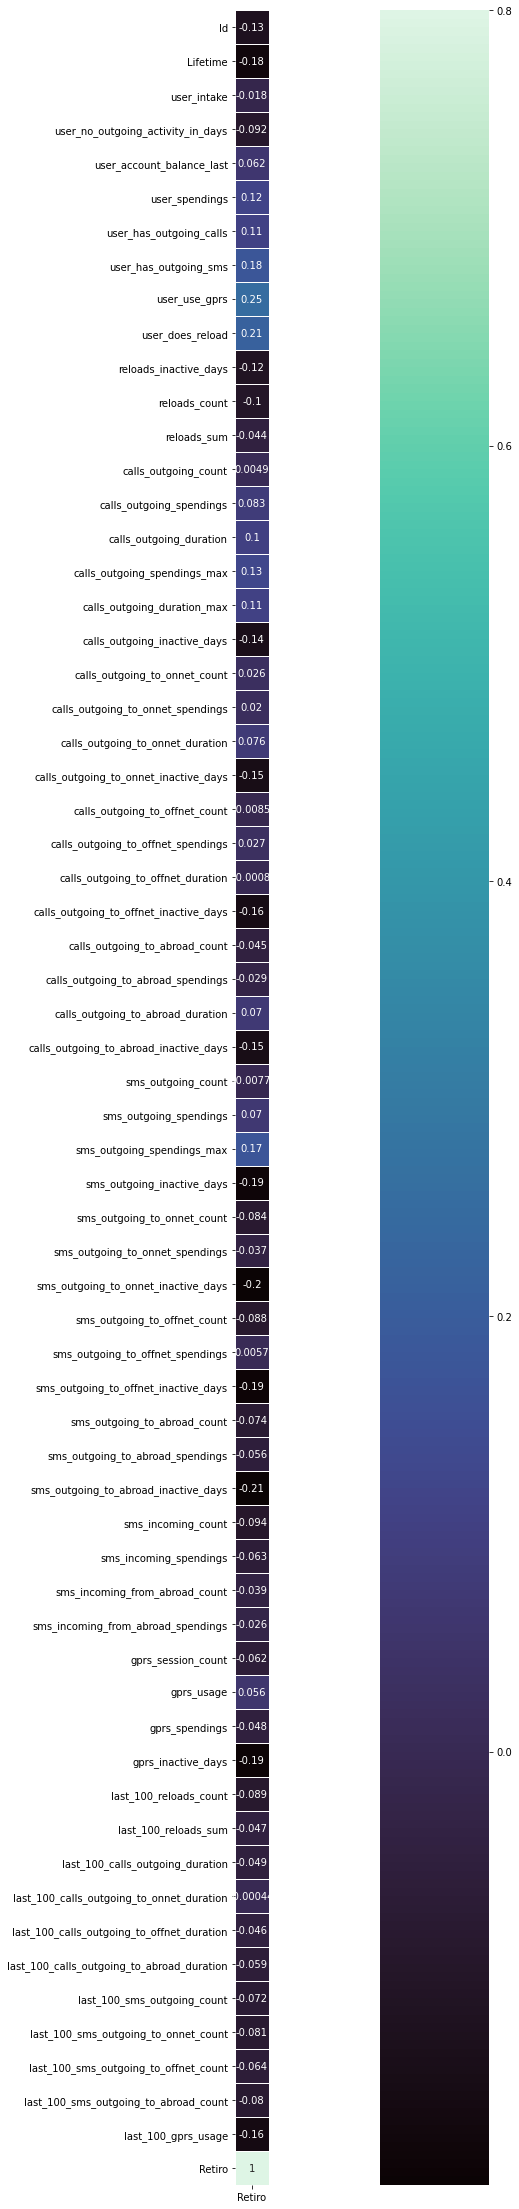

In [9]:
# Matriz de correlaciones
m_corre = dt_file.corr()
f, ax = plt.subplots(figsize=(40, 40))
sns.heatmap(m_corre[["Retiro"]], vmax=.8, square=True, cmap="mako", robust= True, annot=True,linewidths=.5);

Extraeremos las 10 variables que tengan la correlación más alta con nuestra variable independiente ('Retiro').

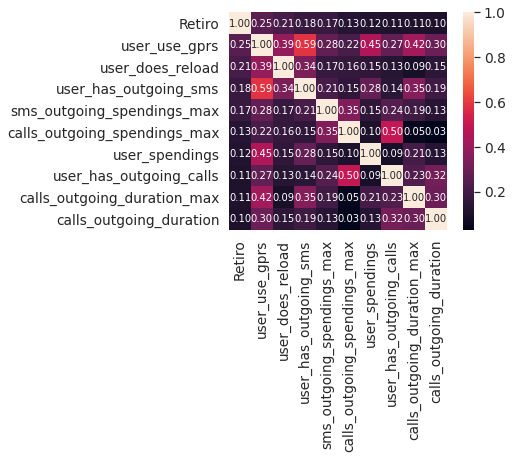

In [10]:
# Extraer las 10 variables con mayor correlación con nuestra variable dependiente ('Retiro')
top_10 = 10 
cols = m_corre.nlargest(top_10, 'Retiro')['Retiro'].index
cm = np.corrcoef(dt_file[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

Las siguientes variables tienen una correlación baja "inferior a 0.29" con la variable dependiente ('Retiro'), sin embargo son las que más correlación tienen.
* user_use_gprs
* user_does_reload
* user_has_outgoing_sms 
* sms_outgoing_spendings_maxcalls_out
* going_spendings_max
* user_spendings
* user_has_outgoing_calls
* calls_outgoing_duration_max
* calls_outgoing_duration<br>

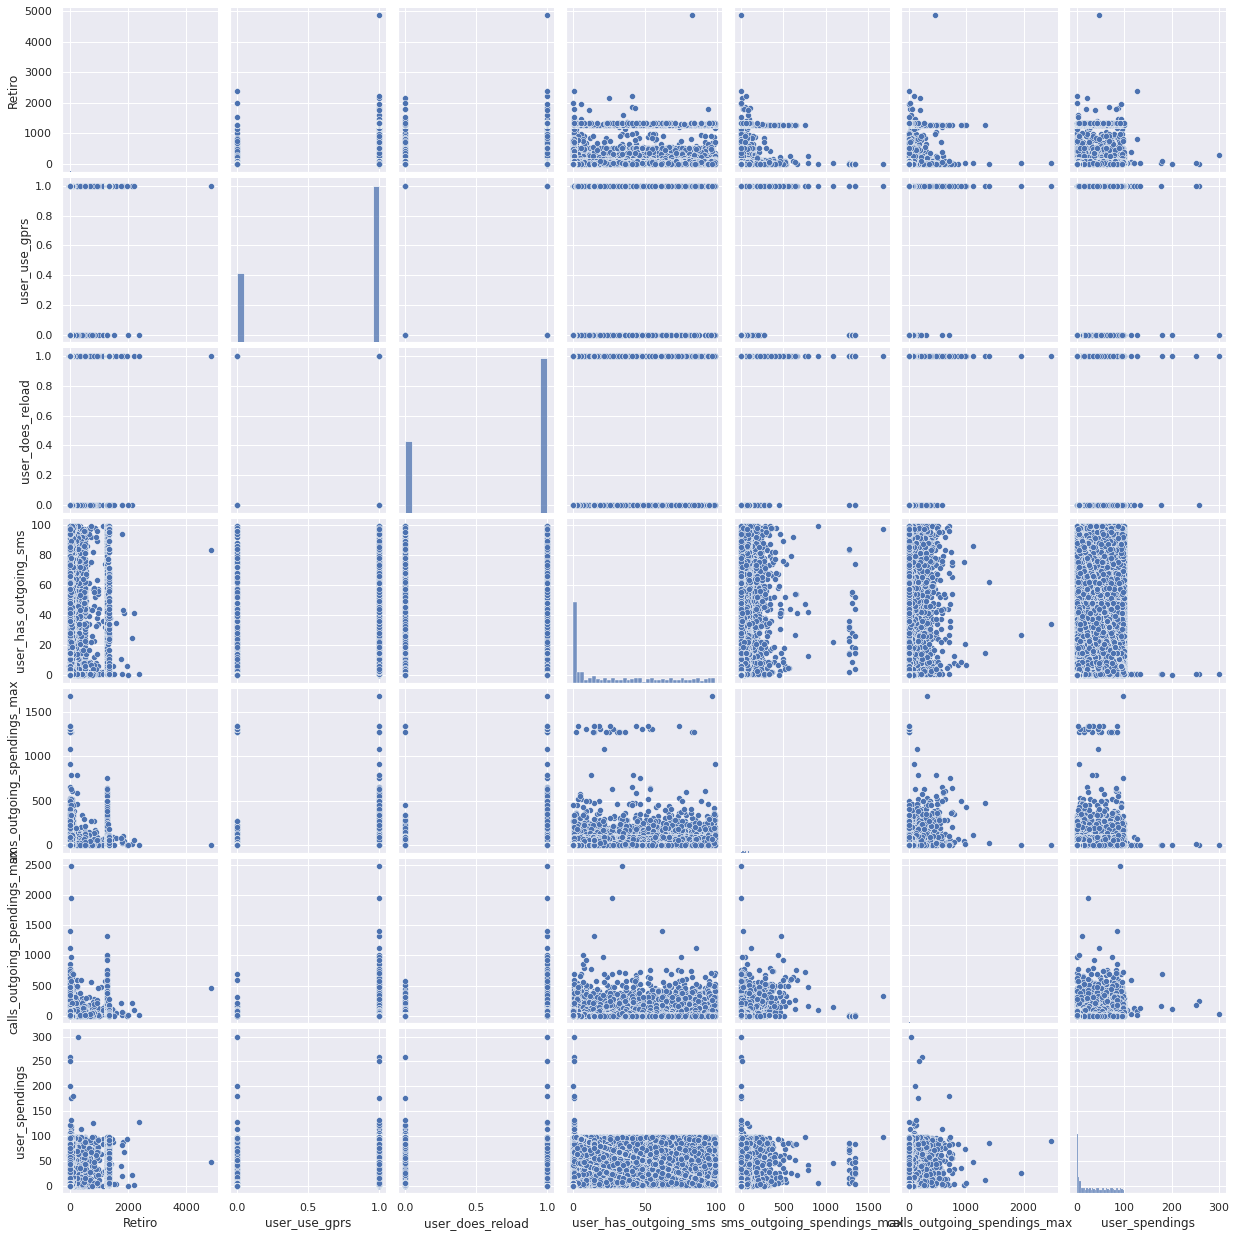

In [11]:
sns.set()
cols = ['Retiro', 'user_use_gprs', 'user_does_reload', 'user_has_outgoing_sms', 'sms_outgoing_spendings_max', 'calls_outgoing_spendings_max', 'user_spendings']
sns.pairplot(dt_file[cols], size = 2.5)
plt.show();

**Del gráfico anterior se pueden sacar los siguientes insights**<br>
* La variable Retiro tiene un valor atípico ('4859') que está afectando al comportamiento de las otras variables. Dicho valor proviene de un solo usuario.
* Los usuarios que tienen un sms_outgoing_spendings_max inferior a 1000 representan la mayoría de retiros.
* Los usuarios que tienen un calls_outgoing_spendings_max inferior a 1500 representan la mayoría de retiros.
* Los usuarios que tienen un user_spendings inferior a 150 representan la mayoría de retiros. 

## 2) Preprocesamiento de la información. <a id="cell3"></a>
**Manejo de datos faltantes y errados.**<br>
Identificar y tratar los datos faltantes y/o errados.


In [12]:
# Identificar los datos faltantes.
total = dt_file.isnull().sum().sort_values(ascending=False)
percent = (dt_file.isnull().sum()/dt_file.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
Retiro,0,0.0
last_100_gprs_usage,0,0.0
calls_outgoing_to_abroad_duration,0,0.0
calls_outgoing_to_abroad_spendings,0,0.0
calls_outgoing_to_abroad_count,0,0.0
calls_outgoing_to_offnet_inactive_days,0,0.0
calls_outgoing_to_offnet_duration,0,0.0
calls_outgoing_to_offnet_spendings,0,0.0
calls_outgoing_to_offnet_count,0,0.0
calls_outgoing_to_onnet_inactive_days,0,0.0


Nuestra data está libre de datos faltantes y errados.

**Manejo de variables categóricas**<br>
Dado que las variables categóricas que existen en la información solo tienen 2 valores no hay necesidad de realizarles un tratamiento especial.

In [13]:
# Seleccionamos las variables categoricas definidas en el paso anterior.
dt_categorical = dt_file[['user_intake','user_use_gprs','user_does_reload']]
dt_categorical.head()

,user_intake,user_use_gprs,user_does_reload
0,0,1,0
1,0,1,0
2,0,1,0
3,0,0,0
4,0,1,0


**Manejo de datos atípicos y skewness.**<br>
* Primero eliminados la columna Id la cual hace referencia al identificador del usuario en la data, este valor no se repite y es ascendente.
* En los datos de la variable dependiente existen dos usuarios con datos negativos los cuales hacen poco sentido, ya que un retiro negativo es anti intuitivo. Por tal motivo se elimina.
* En los datos de la variable dependiente existe un usuario con una cantidad considerable de retiros ('4859') el cual no es representativo de un caso típico por lo tanto se eliminara.
* Se eliminan algunos valores negativos.

In [14]:
# Se eliminan 31 filas en total.
print(dt_file.shape)
dt_file.drop(['Id'], axis=1, inplace=True)
dt_file = dt_file[dt_file['Retiro'] < 4000]
dt_file = dt_file[dt_file['Retiro'] >= 0]
dt_file = dt_file[dt_file['user_has_outgoing_calls'] >= 0]
dt_file = dt_file[dt_file['sms_outgoing_inactive_days'] >= 0]
dt_file = dt_file[dt_file['sms_outgoing_to_abroad_inactive_days'] >= 0]
dt_file = dt_file[dt_file['gprs_usage'] >= 0]
dt_file = dt_file[dt_file['last_100_calls_outgoing_to_onnet_duration'] >= 0]
dt_file = dt_file[dt_file['last_100_calls_outgoing_to_offnet_duration'] >= 0]
dt_file = dt_file[dt_file['last_100_calls_outgoing_duration'] >= 0]
dt_file = dt_file[dt_file['last_100_calls_outgoing_to_abroad_duration'] >= 0]
dt_file = dt_file[dt_file['last_100_sms_outgoing_count'] >= 0]
dt_file = dt_file[dt_file['last_100_gprs_usage'] >= 0]
print(dt_file.shape)

(66469, 64)
(66438, 63)


**Partición de los datos entre variables dependientes y variables independientes.**<br>Separamos las variables independientes de la variable dependiente.

In [15]:
# Variables separadas.
x = dt_file.iloc[:,:-1].values
y = dt_file.iloc[:,62:63].values

**Manejo de datos atípicos y skewness.**<br>
Se tratarán los datos atípicos de las variables anterior mente analizadas.<br>
* Dado que contamos con valores negativos utilizaremos `PowerTransformer(method='yeo-johnson')` de scikit-learn para reducir skewness y tratar los datos atípicos.

In [16]:
x_transformed = PowerTransformer(method='yeo-johnson').fit_transform(x)
y_transformed = PowerTransformer(method='yeo-johnson').fit_transform(y)

Verifiquemos como se ven ahora nuestras variables.

In [17]:
# La siguiente función crea una comparativa del antes y el después
# de aplicar PowerTransformer(method='yeo-johnson') para las variables independientes.
def plots(df, var, t):
    plt.figure(figsize=(13,5))
    plt.subplot(121)
    sns.kdeplot(df[var])
    plt.title('before ' + str(t).split('(')[0])
    
    plt.subplot(122)
    p1 = t.fit_transform(df[[var]]).flatten()
    sns.kdeplot(p1)
    plt.title('after ' + str(t).split('(')[0])

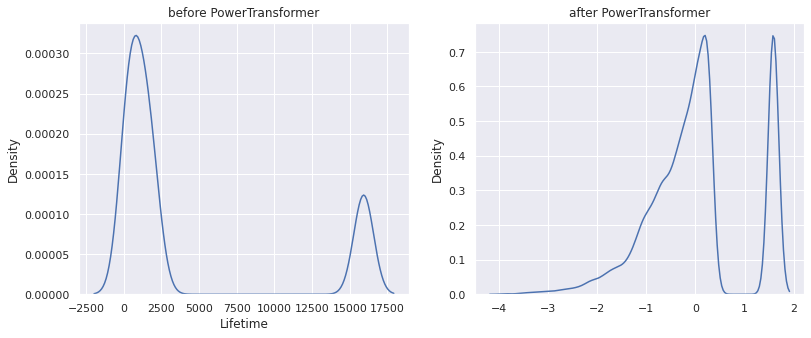

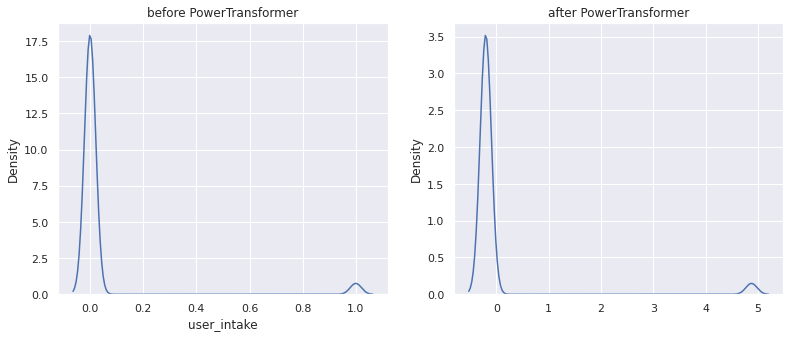

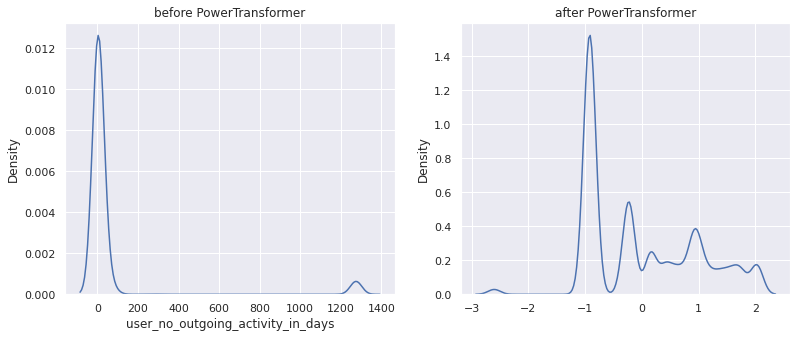

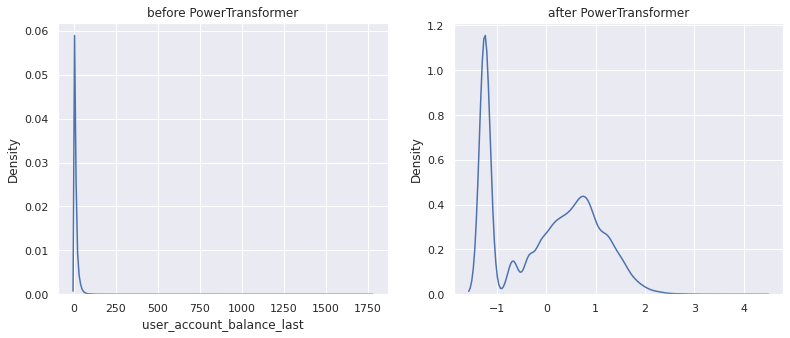

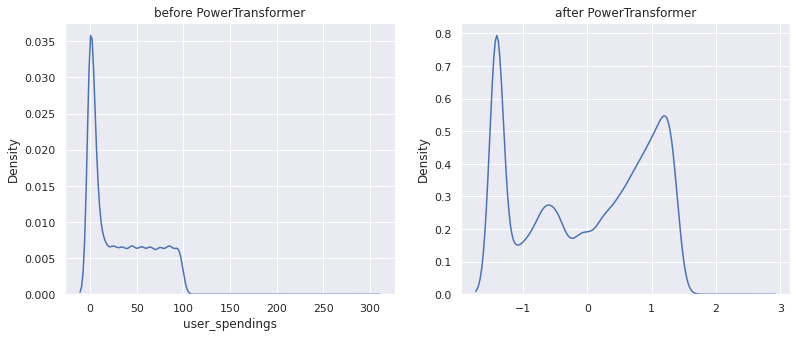

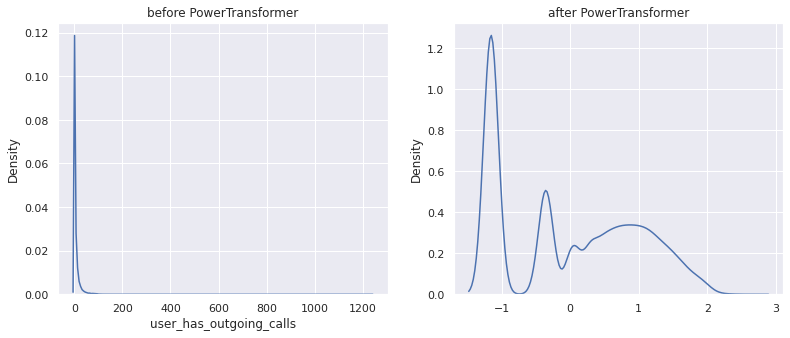

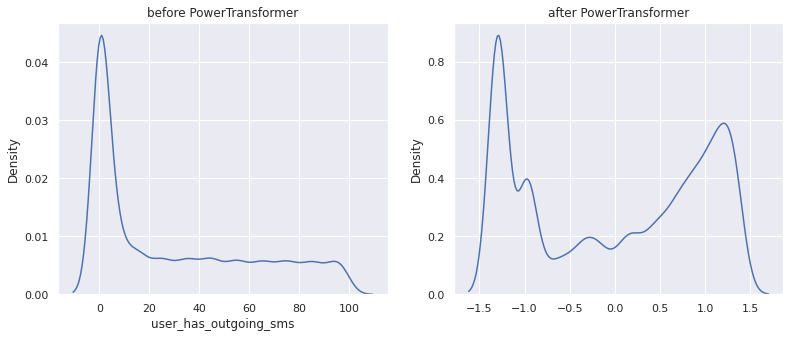

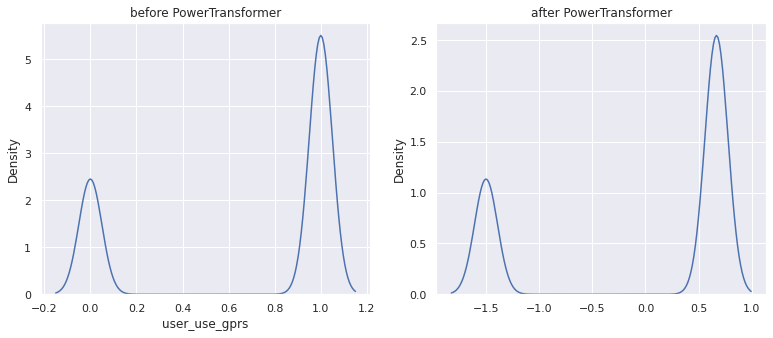

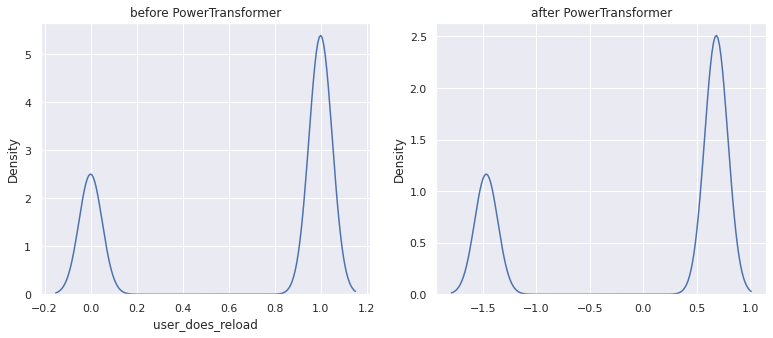

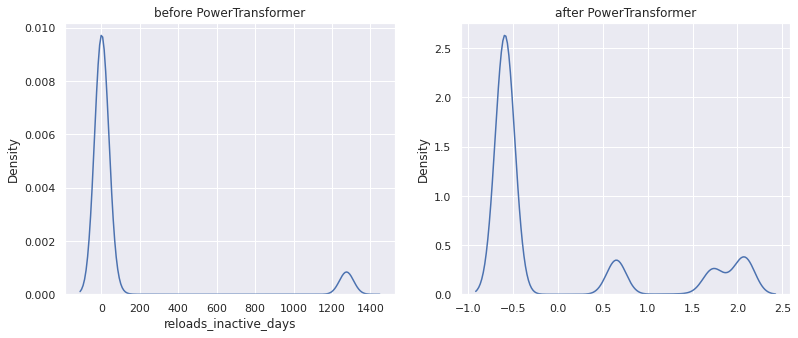

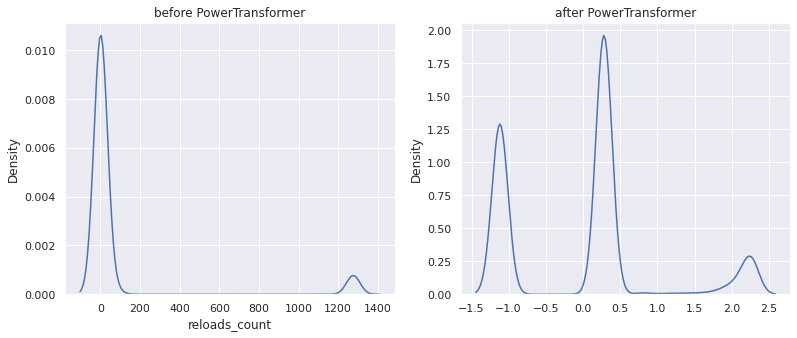

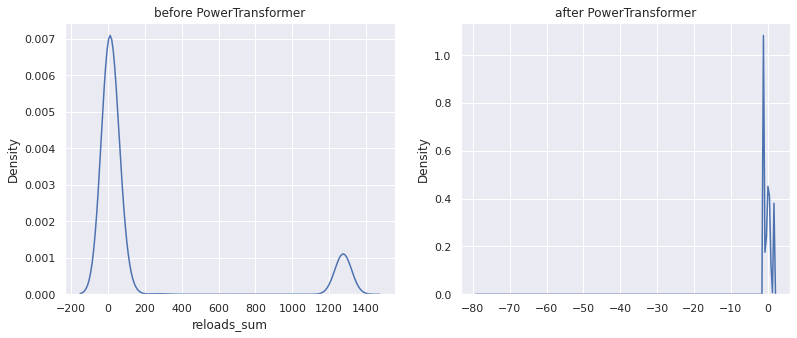

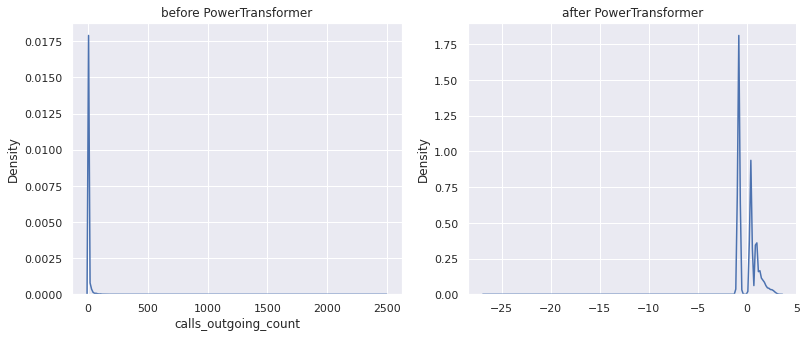

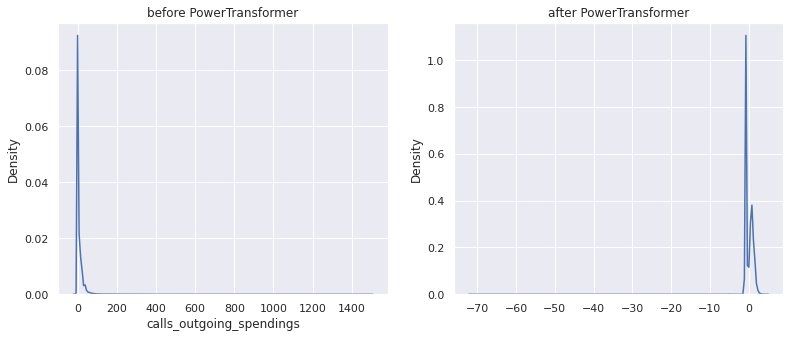

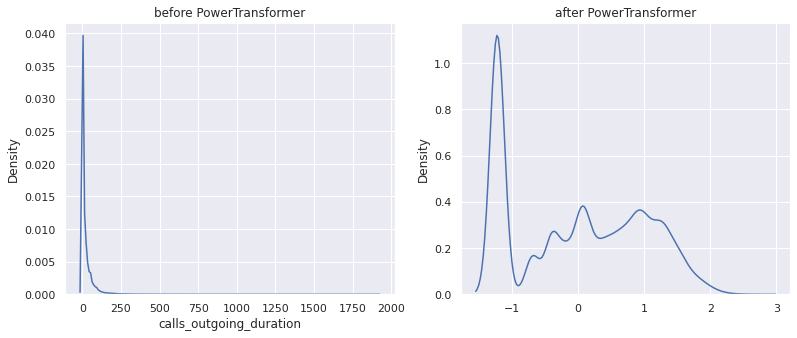

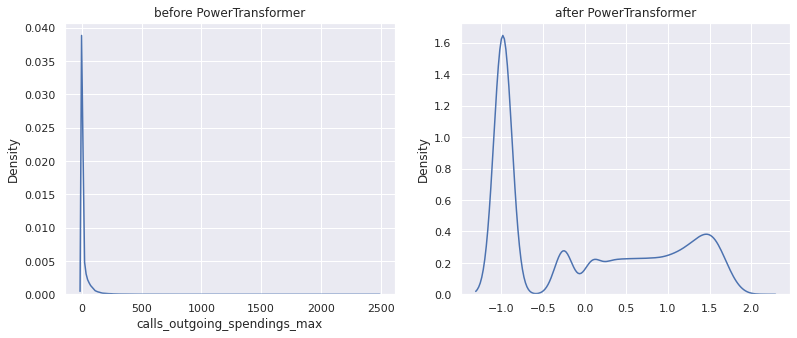

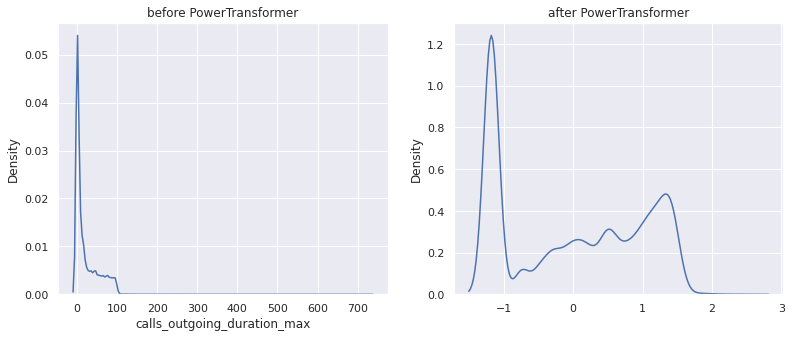

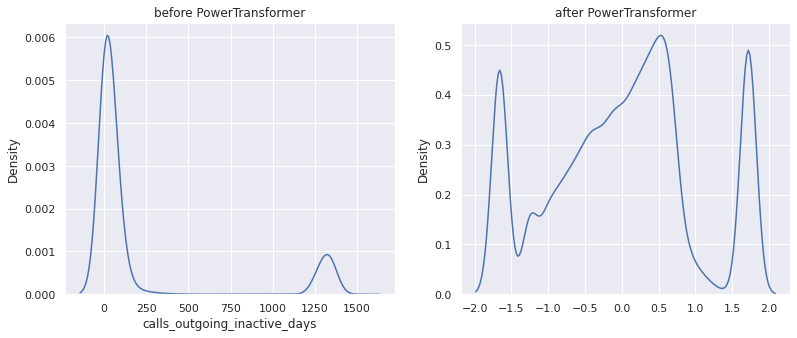

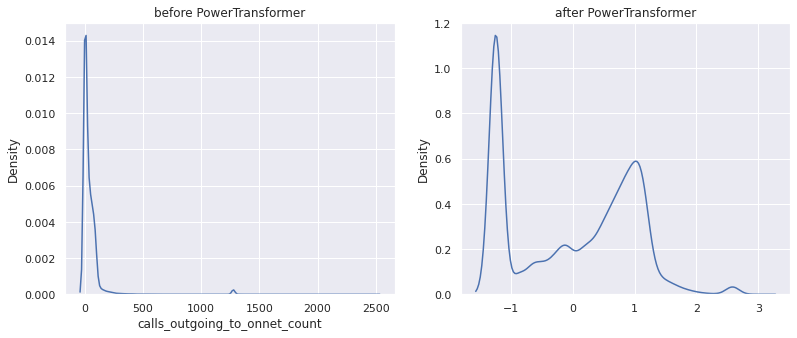

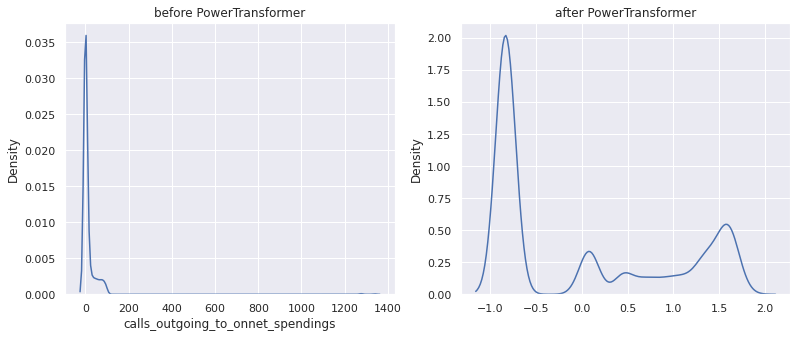

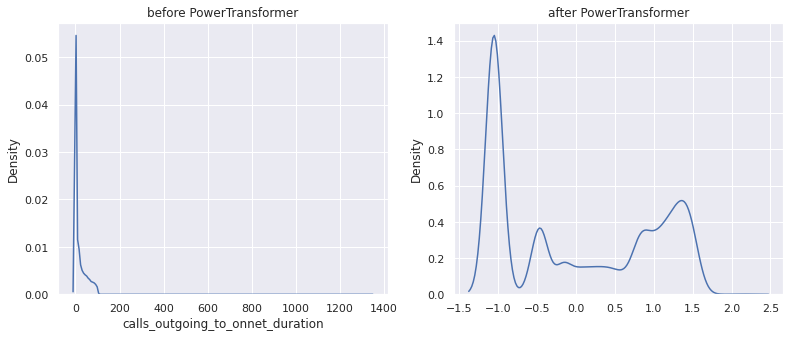

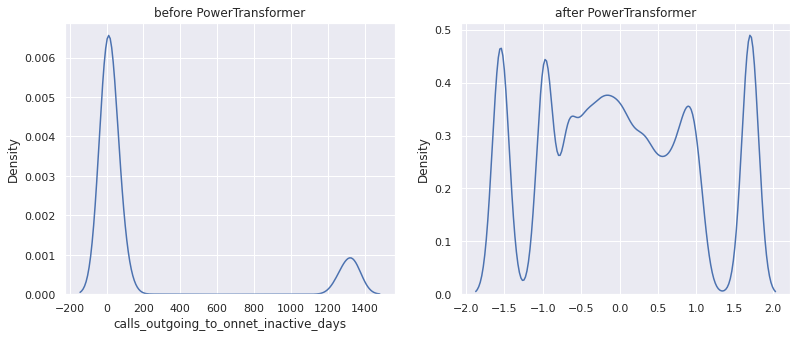

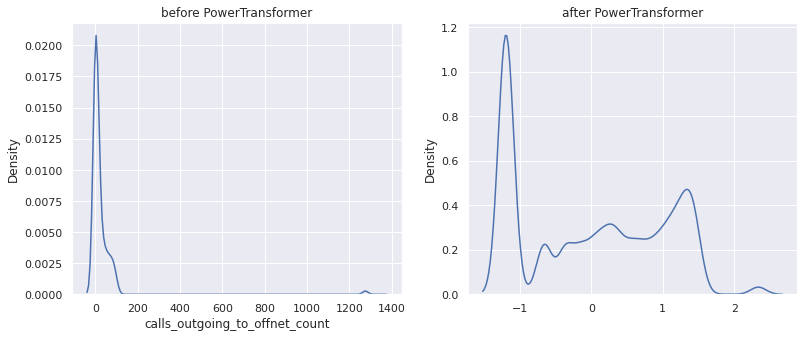

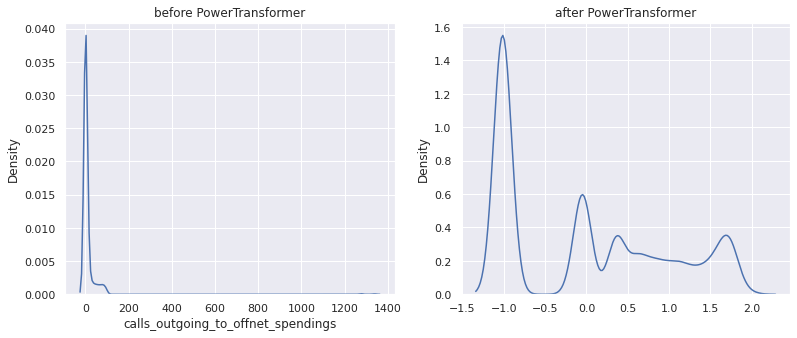

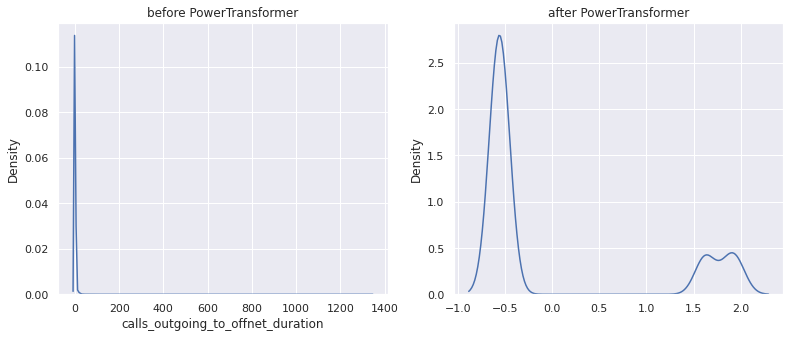

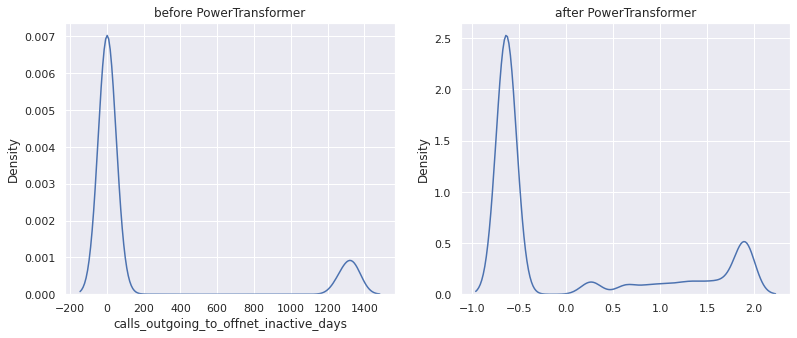

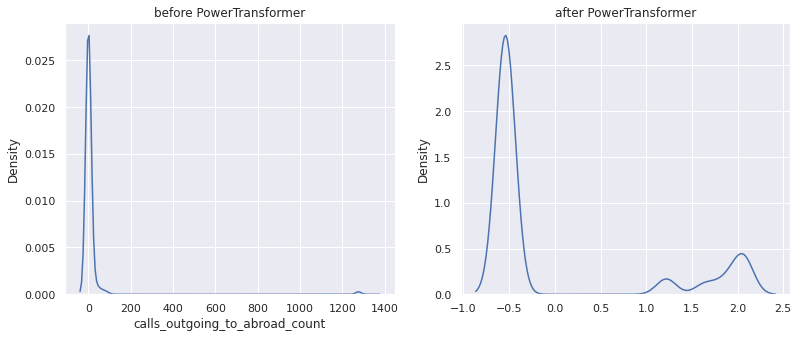

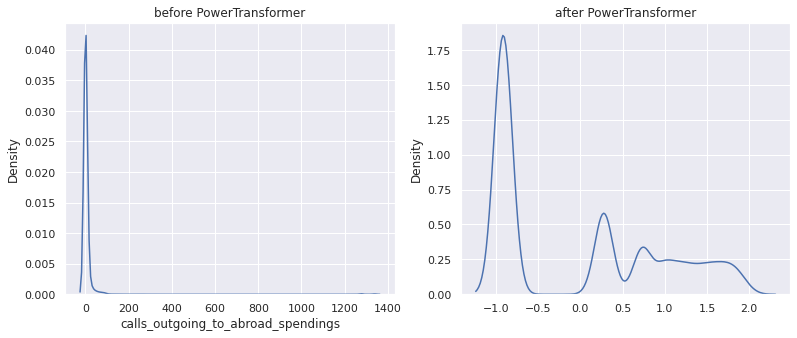

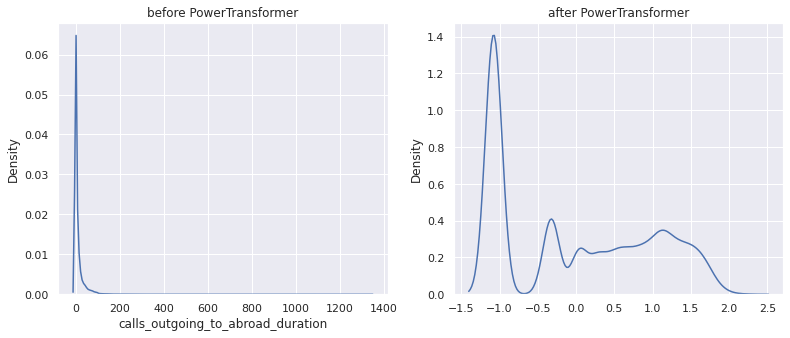

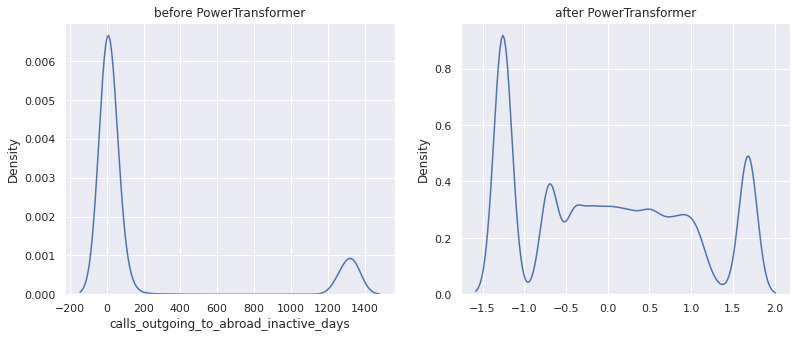

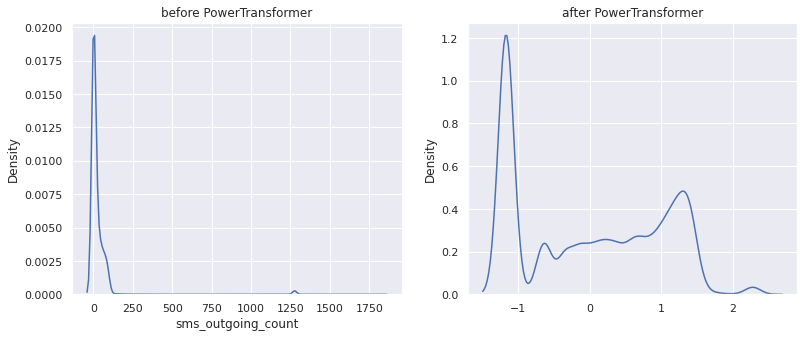

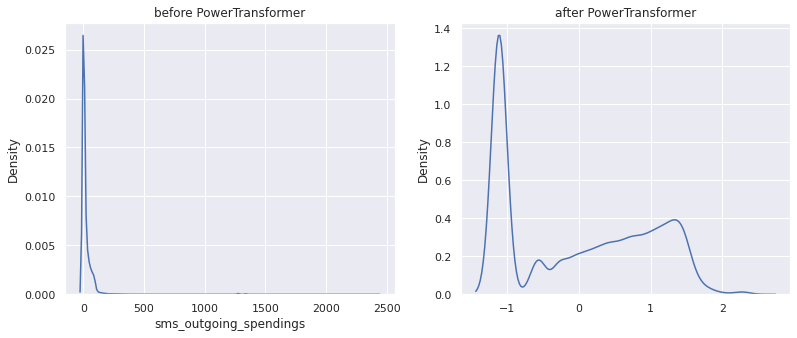

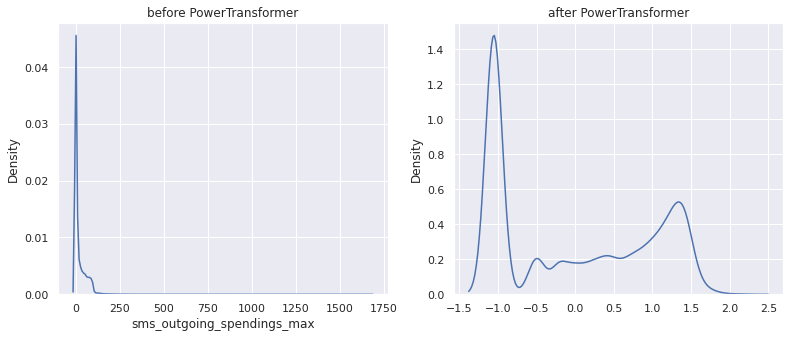

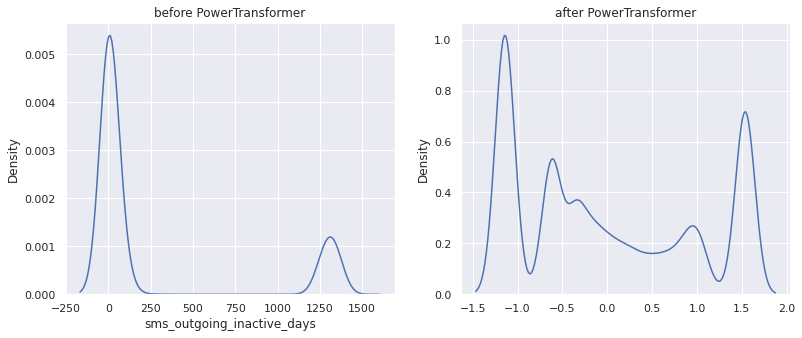

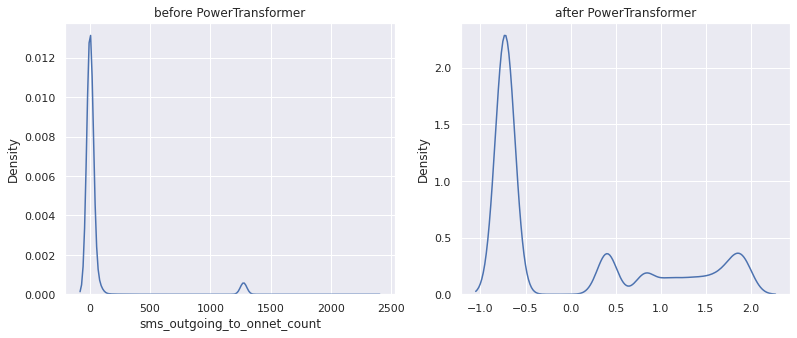

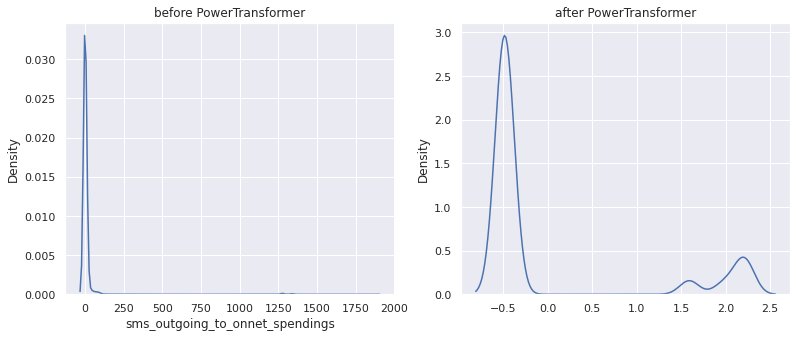

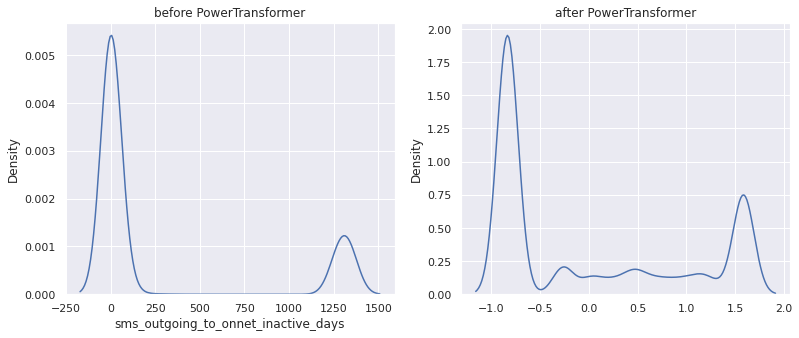

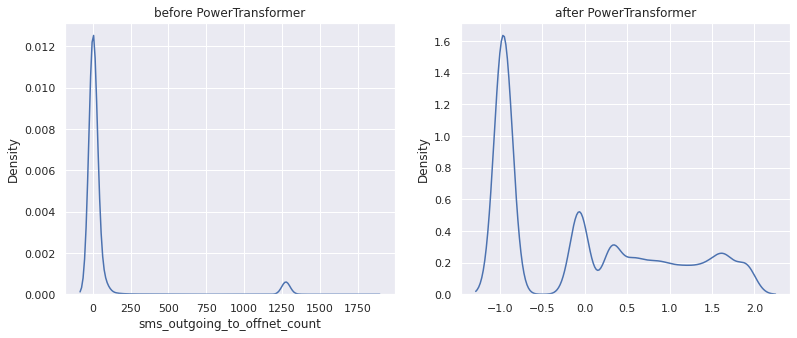

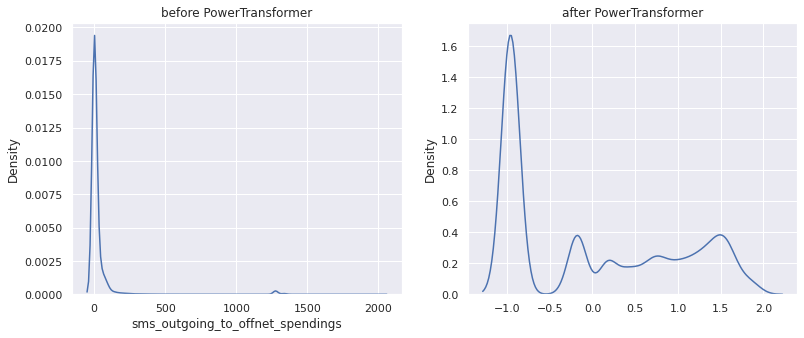

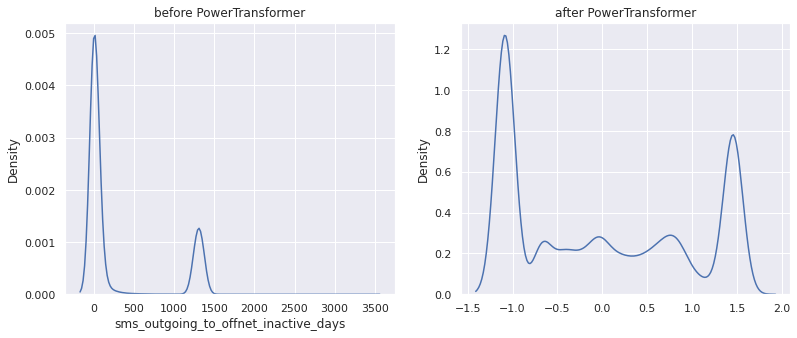

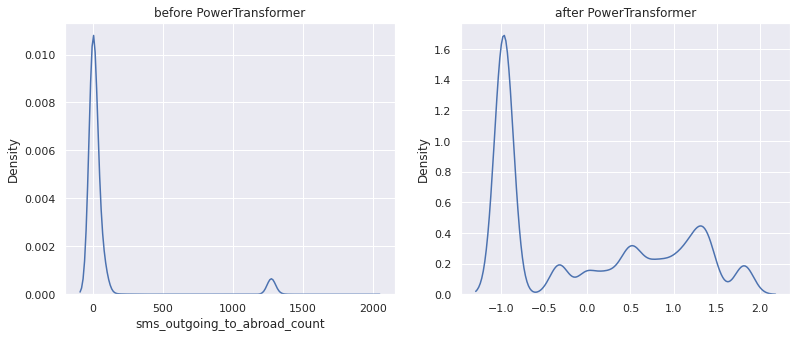

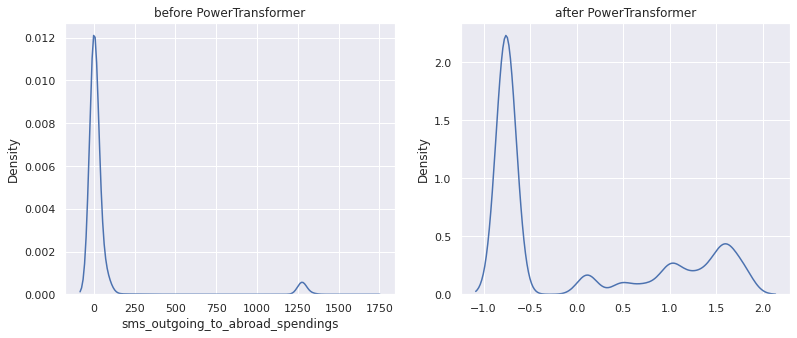

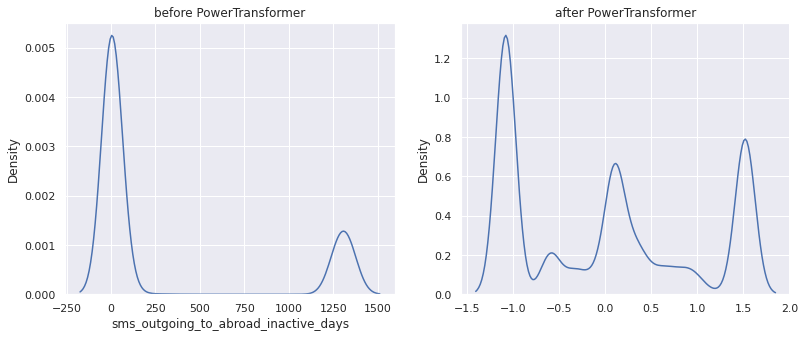

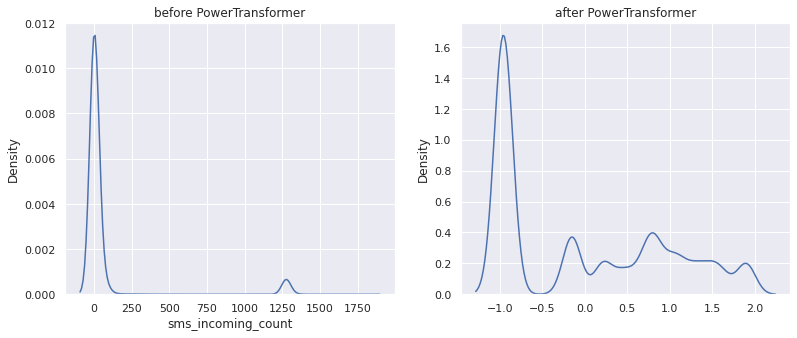

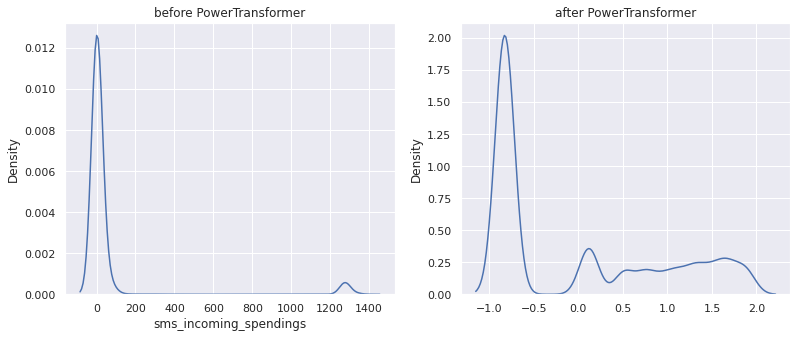

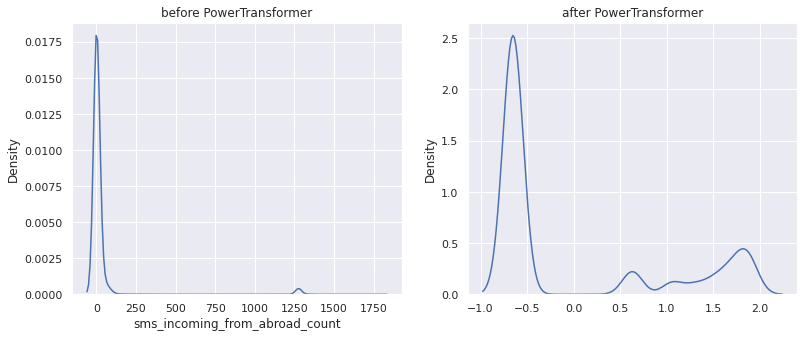

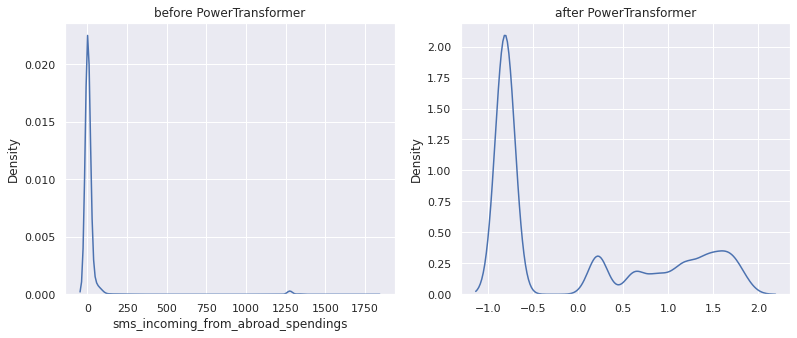

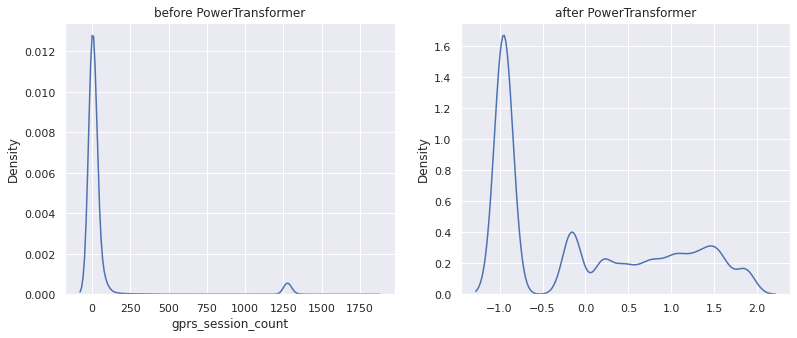

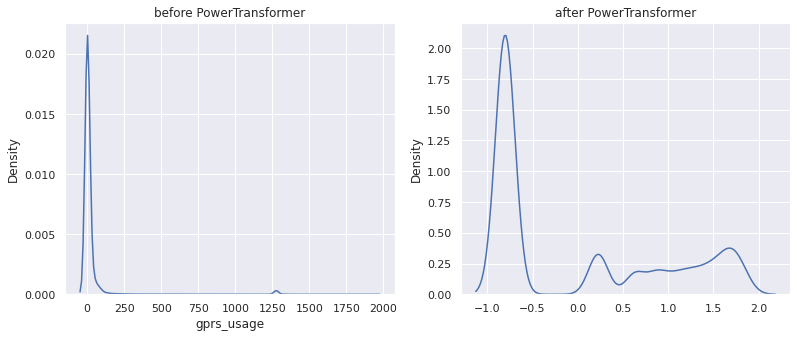

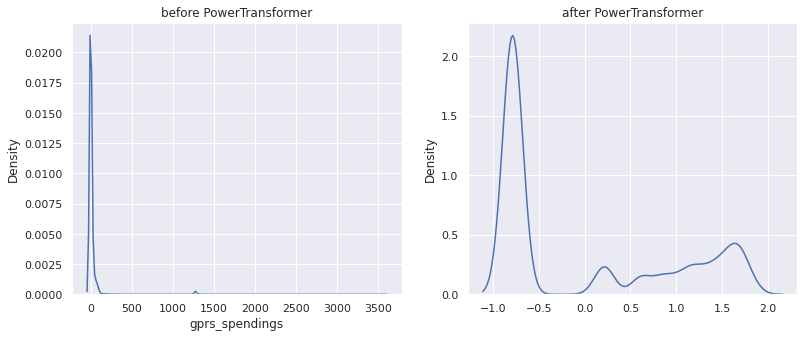

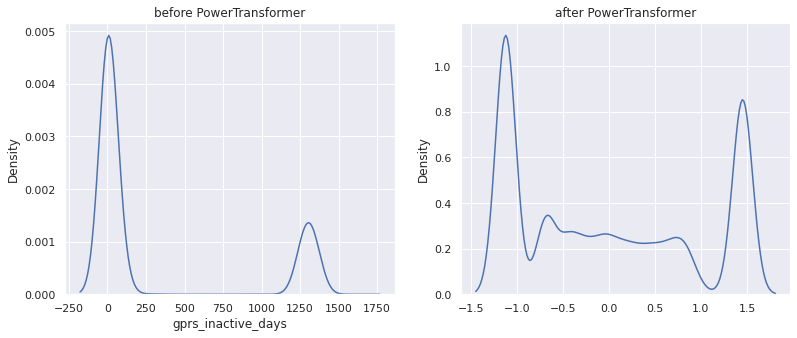

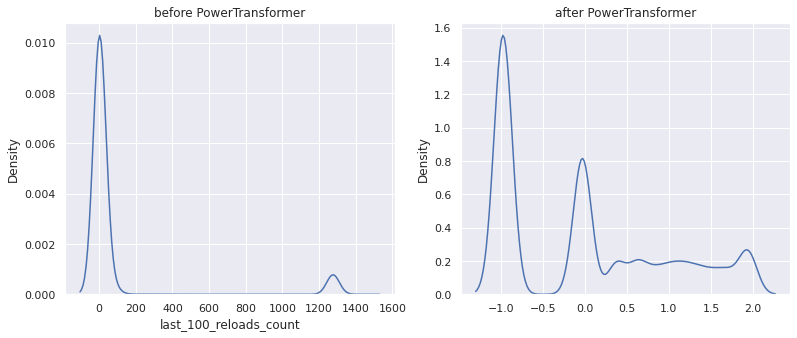

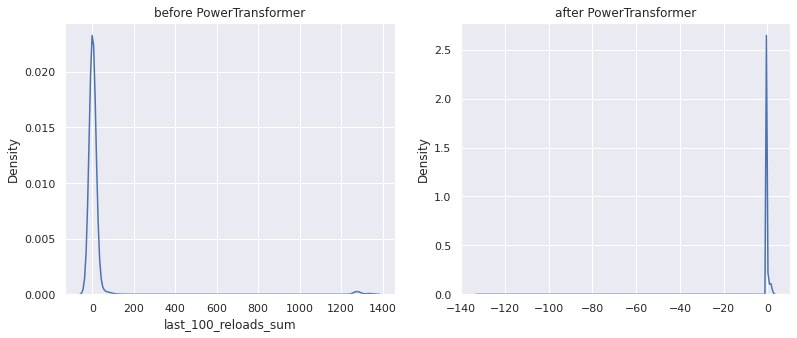

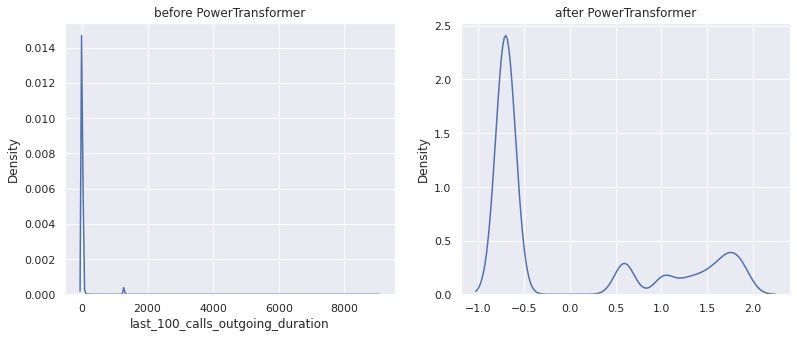

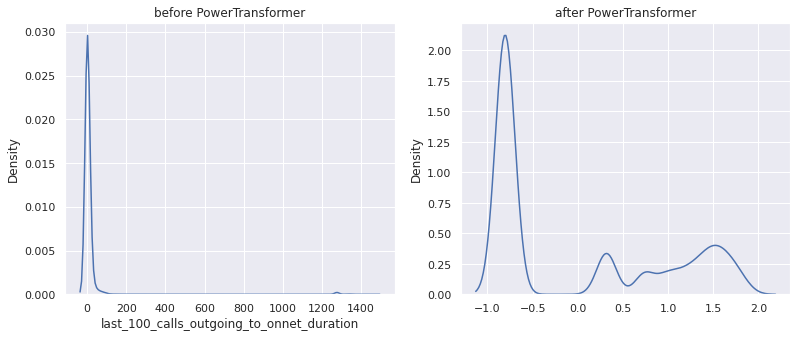

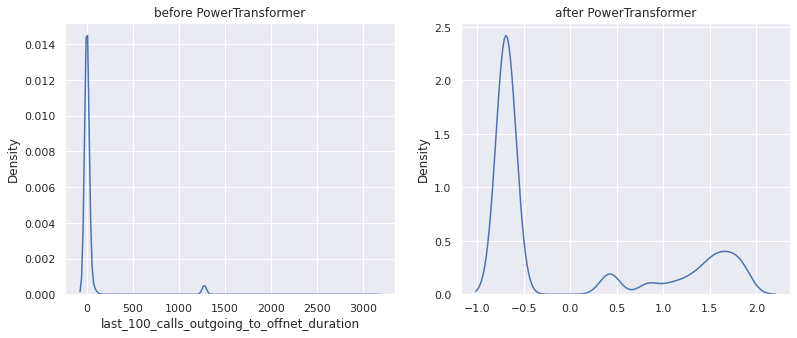

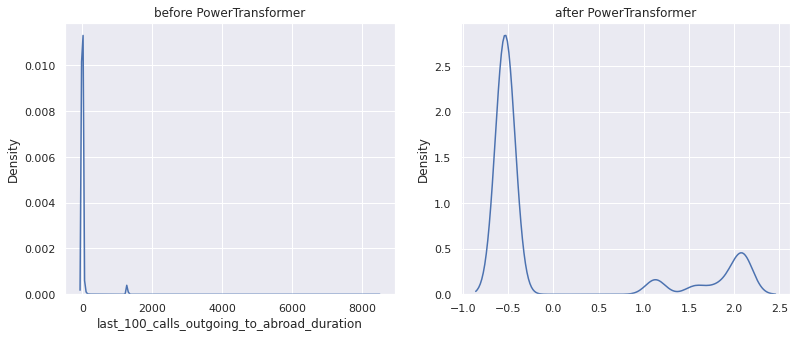

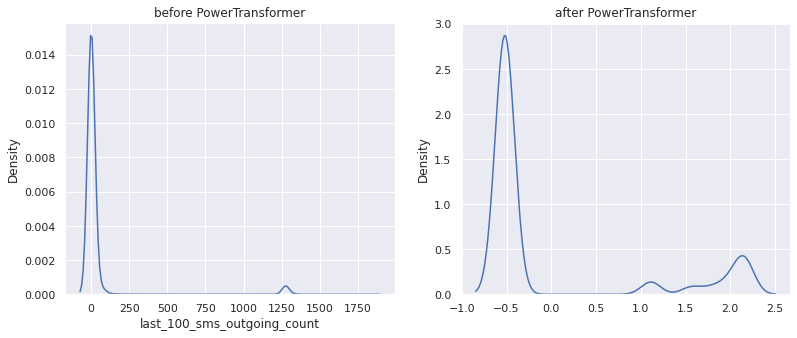

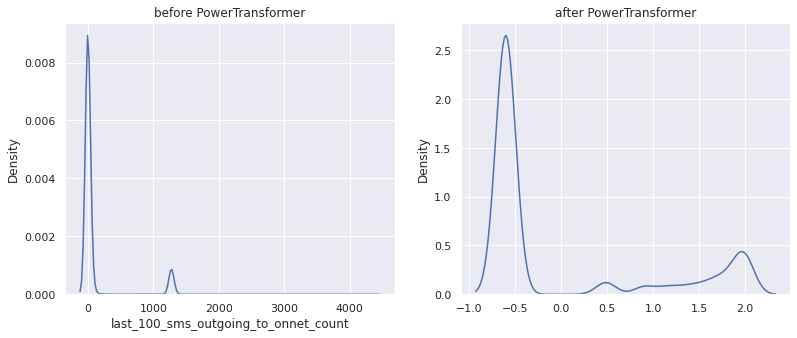

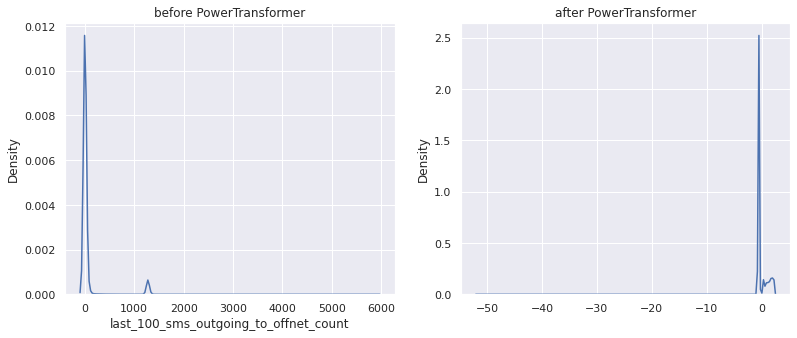

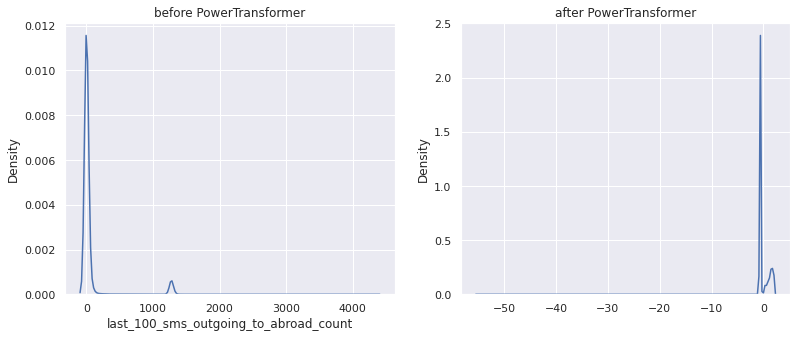

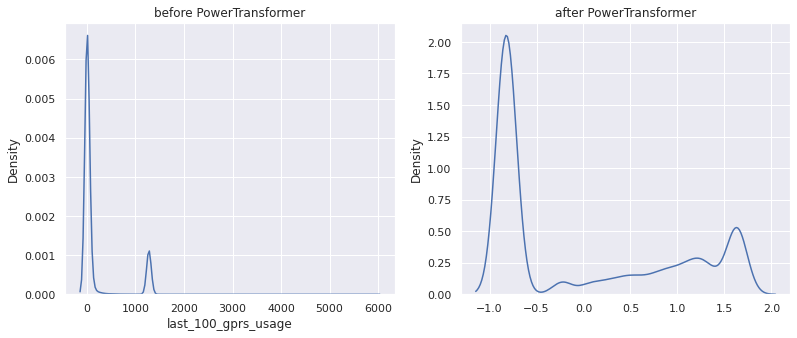

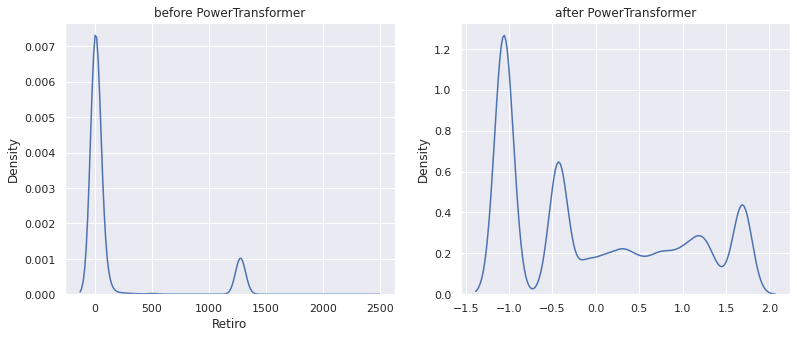

In [18]:
for col in dt_file.columns:
    plots(dt_file, col, PowerTransformer(method='yeo-johnson'))

Verifiquemos como se ve nuestra variable dependiente.

Valores anteriores.

Kurtosis: 3.983621
Skewness: 2.395131

Valores actuales.

kurtosis: -1.2819928661566988
skewness: 0.4159427956751292


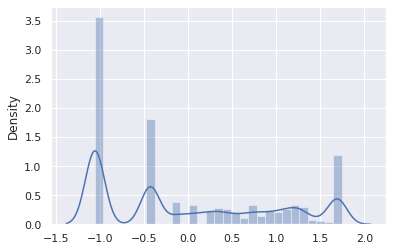

In [19]:
sns.distplot(y_transformed);
print( 'Valores anteriores.')
print('')
print( 'Kurtosis: 3.983621')
print( 'Skewness: 2.395131')
print('')
print( 'Valores actuales.')
print('')
print( 'kurtosis: {}'.format( kurtosis(y_transformed)[0] ))
print( 'skewness: {}'.format( skew(y_transformed)[0] ))

Se logra reducir kurtosis y skewness en las variables dependientes y en la dependiente. Aún existen algunos valores atípicos y asimetría.

**División de los datos (entrenamiento y test)**<br>
Se dividen los datos suministrados de forma aleatoria en una parte de entrenamiento y otra de prueba, con esto nos aseguramos que el modelo pueda entrenarse y luego ponerse a prueba en datos completamente nuevos.

In [20]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)
pt_x = PowerTransformer(method='yeo-johnson')
X_train = pt_x.fit_transform(X_train)
X_test = pt_x.transform(X_test)
pt_y = PowerTransformer(method='yeo-johnson')
y_train = pt_y.fit_transform(y_train)
y_test = pt_y.transform(y_test)

## 3) Creación y evaluación de los modelos.<a id="cell4"></a>

***Identificar patrones por medio de clustering.***<br>
* Se toman todos las variables dadas y se utilizan para crear patrones o clúster que nos permitan identificar similitudes.
* Se utilizará el método 'The Elbow Method' para definir el número óptimo de clúster.

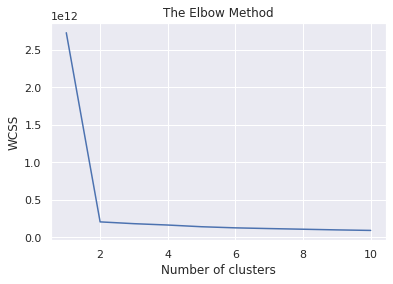

In [21]:
# The Elbow Method.
xy_cluster = dt_file.iloc[:,:].values
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(xy_cluster)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

Como se puede apreciar en la gráfica el número óptimo de clústers según ```The Elbow Method``` es 2.

In [22]:
# Entrenar el modelo kmeans utilizando todos los datos.
kmeans = KMeans(n_clusters = 2, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(xy_cluster)
# Se agrega la nueva variable a los datos.
dt_file['y_kmeans'] = y_kmeans
first_column = dt_file.pop('y_kmeans')
dt_file.insert(2, 'y_kmeans', first_column)
dt_file.head()

,Lifetime,user_intake,y_kmeans,user_no_outgoing_activity_in_days,user_account_balance_last,user_spendings,user_has_outgoing_calls,user_has_outgoing_sms,user_use_gprs,user_does_reload,...,last_100_calls_outgoing_duration,last_100_calls_outgoing_to_onnet_duration,last_100_calls_outgoing_to_offnet_duration,last_100_calls_outgoing_to_abroad_duration,last_100_sms_outgoing_count,last_100_sms_outgoing_to_onnet_count,last_100_sms_outgoing_to_offnet_count,last_100_sms_outgoing_to_abroad_count,last_100_gprs_usage,Retiro
0,1000,0,0,1,0,5,0,1,1,0,...,1276,4,12,1,75,27,0,63,43,0
1,1000,0,0,25,28,31,3,45,1,0,...,0,0,0,0,0,0,0,1276,0,0
2,1005,0,0,8,15,62,1,97,1,0,...,4,0,0,0,0,1276,0,0,30,0
3,1013,0,0,11,5,62,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1032,0,0,2,5,86,0,15,1,0,...,0,0,0,1276,1,6,2,58,0,1


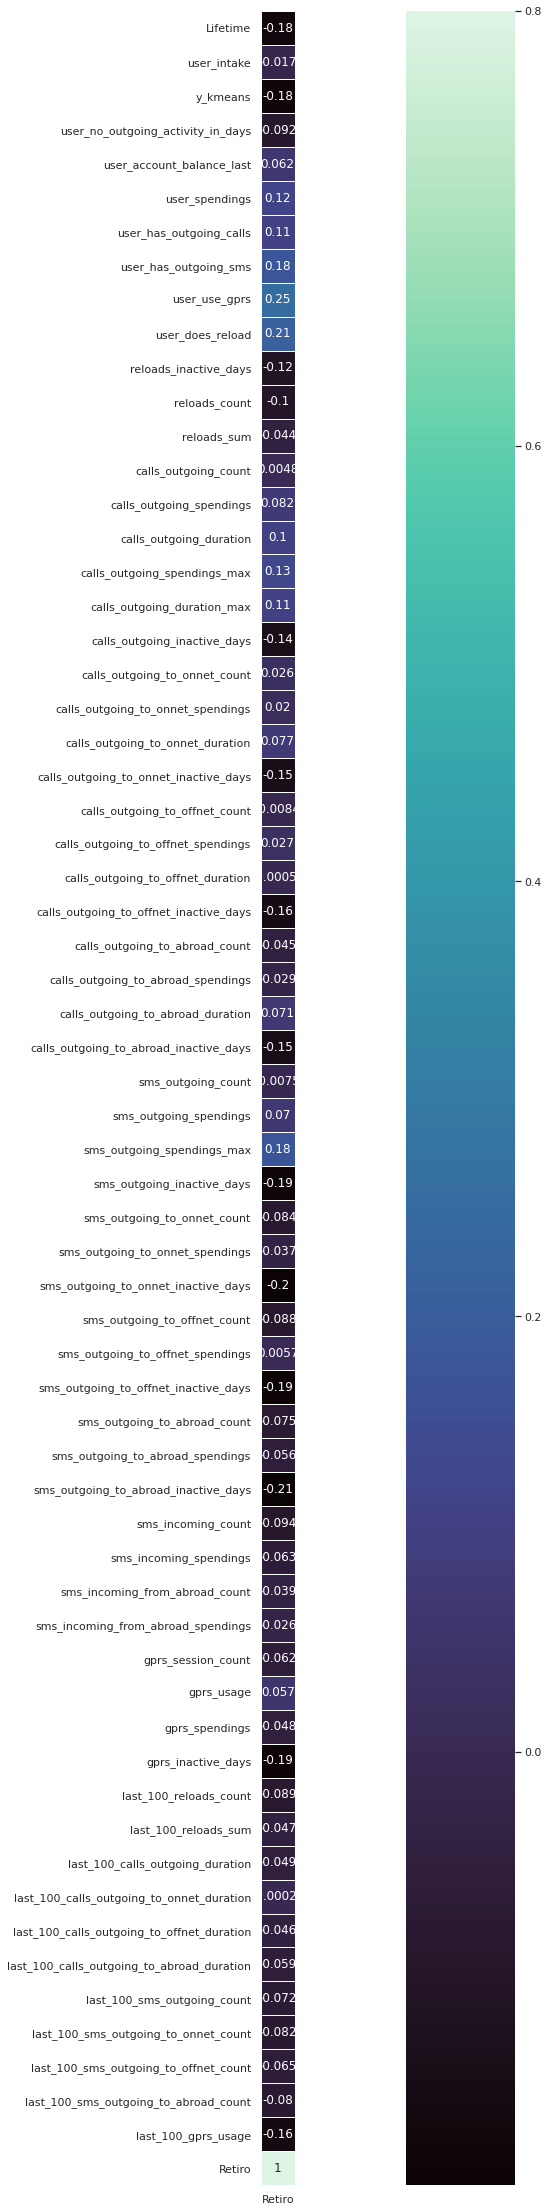

In [23]:
m_corre = dt_file.corr()
f, ax = plt.subplots(figsize=(40, 40))
sns.heatmap(m_corre[["Retiro"]], vmax=.8, square=True, cmap="mako", robust= True, annot=True,linewidths=.5);

La nueva variable creada ('y_kmeans') tiene una correlación negativa `-0.18` y baja respecto a la variable dependiente.

**Reducción de dimensiones.**<br>
Se utilizará PCA para encontrar relaciones entre nuestras variables independientes y de esta forma crear dos nuevas variables que las describan, Algo importante a resaltar es que la correlación de nuestras variables independientes respecto a nuestra variable dependiente es inferior a 0.3 lo cual afecta al PCA.

Text(0, 0.5, 'Second Principal Component')

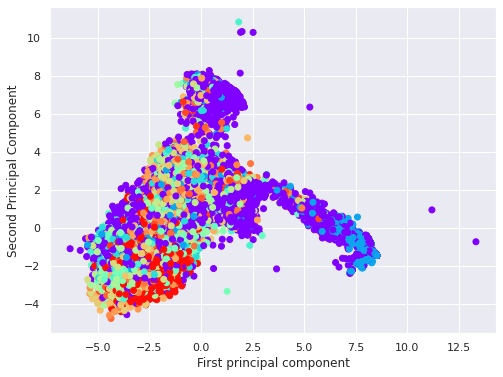

In [24]:
pca = PCA(n_components = 2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
plt.figure(figsize=(8,6))
plt.scatter(X_train_pca[:,0],X_train_pca[:,1],c=y_train,cmap='rainbow')
#plt.scatter(X_test[:,0],X_test[:,1],c=y_test,cmap='rainbow')
plt.xlabel('First principal component')
plt.ylabel('Second Principal Component')

La poca correlación de las variables dependientes y la variable dependiente está teniendo un efecto importante.<br>
No se logra distinguir con claridad las nuevas clases creadas.

**Identificar el modelo que presente el mejor rendimiento.**<br>
* Dado que nuestra variable dependiente es continua se requiere usar un modelo que logre predecir valores continuos, por tal motivo se aplican modelos de regresión.
* Se realizaran varios modelos y se evaluaran con base en su coeficiente de determinación. Se utilizará esta métrica, ya que permite identificar que tan alejado estuvo la predicción del modelo respecto al valor real, Un r2_score cercano a 1 significa que el modelo predijo con un gran porcentaje de asertividad el valor de la variable dependiente.
* El modelo que tenga el valor más alto en```r2_score_train```y en``` r2_score_test``` será el modelo que se seleccione.

**1) xgboost.**

In [25]:

regresor  = XGBRegressor()
regresor.fit(X_train, y_train)
y_pred = regresor.predict(X_test)
y_pred_train = regresor.predict(X_train)

In [26]:
print("r2_score_train ")
print(r2_score(y_train,y_pred_train))
print("r2_score_test ")
print(r2_score(y_test,y_pred))

r2_score_train 
0.912400339860851
r2_score_test 
0.8595849013473136


El modelo tiene un desempeñó pobre en los datos de prueba y en los datos de testeo.

**2) Ramdonforest**

In [ ]:
regresor = RandomForestRegressor(n_estimators=700,criterion="mse",n_jobs=-1,random_state=2,max_leaf_nodes=10000,bootstrap=True,min_impurity_split=0.000001,min_samples_split=20)
regresor.fit(X_train,y_train.ravel())
y_pred = regresor.predict(X_test)
y_pred_train = regresor.predict(X_train)

In [ ]:
print("r2_score_train ")
print(r2_score(y_train,y_pred_train))
print("r2_score_test ")
print(r2_score(y_test,y_pred))

El modelo tiene un desempeñó bajo en los datos de prueba y un desempeñó pobre en los datos de testeo, tiene una clara señal de overfeeding.

3) **ElasticNet**

In [ ]:
regresor = ElasticNet(alpha=1e-15, copy_X=False, fit_intercept=True, l1_ratio=0.5,max_iter=10, normalize=True, positive=False, precompute=False,random_state=None, selection='cyclic', tol=0.00000000001, warm_start=False)
regresor.fit(X_train,y_train.ravel())
y_pred = regresor.predict(X_test)
y_pred_train = regresor.predict(X_train)

In [ ]:
print("r2_score_train ")
print(r2_score(y_train,y_pred_train))
print("r2_score_test ")
print(r2_score(y_test,y_pred))

El modelo tiene un desempeñó bajo en los datos de prueba y un desempeñó bajo en los datos de testeo

**4) GradientBoostingRegressor**

In [ ]:
regresor = GradientBoostingRegressor(alpha=0.9,learning_rate=0.1,n_estimators=2000, loss='ls')
regresor.fit(X_train,y_train.ravel())
y_pred = regresor.predict(X_test)
y_pred_train = regresor.predict(X_train)

In [ ]:
print("r2_score_train ")
print(r2_score(y_train,y_pred_train))
print("r2_score_test ")
print(r2_score(y_test,y_pred))

El modelo tiene un desempeñó pobre en los datos de prueba y en los datos de testeo.

**El modelo con mayor ```r2_score_train``` y ```r2_score_test``` es ```xgboost```**

**Notas finales respecto a los modelos.**
* Los modelos tuvieron un desempeñó pobre, no lograron crear funciones que representen la relación de las variables independientes con la variable dependiente.
* No deberían ser usados en ambientes de producción.
* Se requiere tener más data y/o variables independientes que describan mejor la variable independiente.

## 4) Solución final y propuesta<a id="cell5"></a>

**Notas generales**
* Como se expuso en el apartado ```Conocer la información``` la variable dependiente tiene unos datos que son poco intuitivos, ya que no se percibe una relación con las variables independientes de cada usuario. 
* Luego de realizar el respectivo análisis se logró confirmar que la variable dependiente carece de correlación con las variables independientes, con esto en mente se decidió explorar en un plano dimensional superior con PCA y tampoco se logró identificar relaciones.
* El resultado de los modelos de Maching Learning demuestran la poca generalización que tienen las variables independientes a la hora de predecir la variable dependiente.

**Solución** <br>
Con el fin de cumplir el objetivo de ```Identificar de forma anticipada el retiro de clientes para el siguiente periodo.``` Se propone el siguiente proceso.
* Recolectar información sobre variables independientes que estén en concordancia con la variable dependiente a predecir en este caso ```Retiro``` de usuarios de la empresa.
* Crear el modelo de Maching Learning asegurándose de obtener un porcentaje de asertividad mayor a 90% o 0.9 r2 score.
* Desplegar el modelo en AWS de Amazon y hacerlo accesible por medio de API REST a los desarrolladores de la compañía los cuales podrían utilizar el modelo para crear formularios en línea o aplicativos de escritorio con los cuales la persona encargada de analizar el retiro de un usuario lo pueda hacer desde una página web o desde su computador.